# Explore Exercises

These exercises should go in a notebook or script named `explore`.

Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

In [1]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns



In [31]:
import matplotlib as mpl


In [3]:
from wrangle import wrangle_311


In [2]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/15 14:59:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/02/15 14:59:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv


[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features


[wrangle.py] joining departments



df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only show

- How many different cases are there, by department?


In [5]:
case = spark.read.csv("case.csv", sep=",", header=True, inferSchema=True)
dept = spark.read.csv("dept.csv", sep=",", header=True, inferSchema=True)
source = spark.read.csv("source.csv", sep=",", header=True, inferSchema=True)

In [6]:
# Joining the data frames:
df = case.join(dept, 'dept_division', 'left').join(source, 'source_id', 'left')

In [7]:
df.show(2, vertical=True, truncate=False)

-RECORD 0------------------------------------------------------
 source_id              | svcCRMLS                             
 dept_division          | Field Operations                     
 case_id                | 1014127332                           
 case_opened_date       | 1/1/18 0:42                          
 case_closed_date       | 1/1/18 12:29                         
 SLA_due_date           | 9/26/20 0:42                         
 case_late              | NO                                   
 num_days_late          | -998.5087616000001                   
 case_closed            | YES                                  
 service_request_type   | Stray Animal                         
 SLA_days               | 999.0                                
 case_status            | Closed                               
 request_address        | 2315  EL PASO ST, San Antonio, 78207 
 council_district       | 5                                    
 dept_name              | Animal Care Se

In [11]:
case_dept = df.groupby(df.dept_name).count().toPandas()


dept_name  count
9          City Council     34
1                  None    198
3  Development Services   1397
5      Customer Service   2889
6          Metro Health   5313

In [13]:
case_dept.sort_values('count', ascending = False).head(10)

dept_name   count
8  Code Enforcement Services  321984
2     Solid Waste Management  286287
0       Animal Care Services  119362
4   Trans & Cap Improvements   97841
7       Parks and Recreation   19964
6               Metro Health    5313
5           Customer Service    2889
3       Development Services    1397
1                       None     198
9               City Council      34

In [9]:
case_dept = case_dept.sort_values(by='count', ascending=False).reset_index(drop=True)


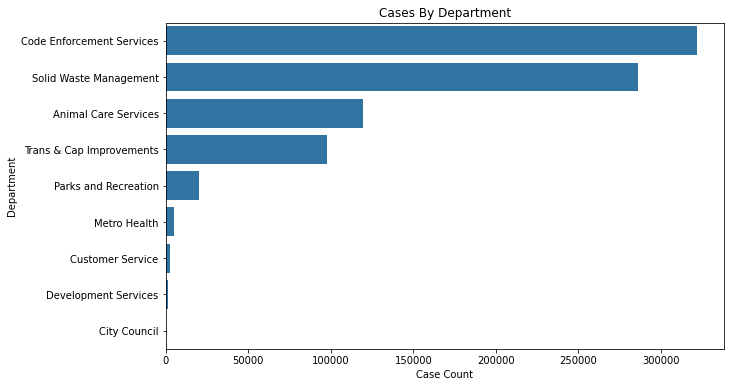

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(x="count", y="dept_name", data=case_dept, color="tab:blue")
plt.title('Cases By Department')
plt.xlabel('Case Count')
plt.ylabel('Department')
plt.show()

- Does the percentage of cases that are late vary by department?


In [17]:
df.createOrReplaceTempView('df')


In [25]:
percent_late = spark.sql('''
SELECT dept_name, AVG(
    CASE 
        WHEN case_late = 'YES' Then 1
        ELSE 0 
    END) * 100 AS pct_case_late
FROM df
GROUP BY dept_name
''').toPandas()

In [51]:
percent_late.sort_values('pct_case_late', ascending = False).head(25)


dept_name  pct_case_late
0           Customer Service      70.439598
1                       None      66.666667
2       Development Services      60.128848
3       Animal Care Services      19.898293
4       Parks and Recreation      19.084352
5               Metro Health      16.073781
6     Solid Waste Management      11.781534
7  Code Enforcement Services       7.909399
8   Trans & Cap Improvements       5.651005
9               City Council       0.000000

In [28]:
percent_late = percent_late.sort_values(by='pct_case_late', ascending=False, ignore_index=True)


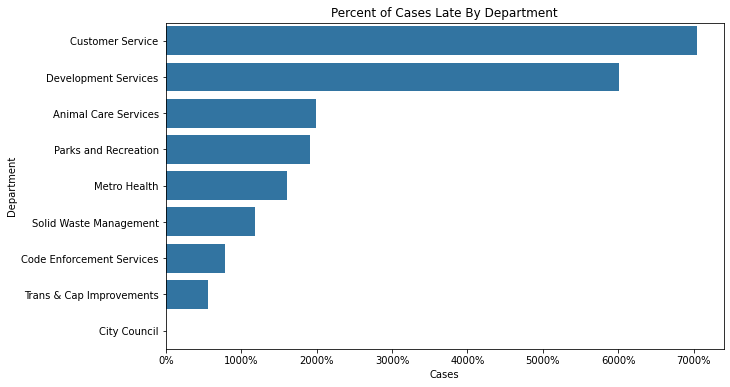

In [32]:
plt.figure(figsize=(10, 6))
sns.barplot(x="pct_case_late", y="dept_name", data=percent_late, color="tab:blue")
plt.title('Percent of Cases Late By Department')
plt.xlabel('Cases')
plt.ylabel('Department')
plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter("{:.0%}".format))
plt.show()

- On average, how late are the late cases by department?


In [33]:
df.show(1, vertical=True, truncate=False)


-RECORD 0------------------------------------------------------
 source_id              | svcCRMLS                             
 dept_division          | Field Operations                     
 case_id                | 1014127332                           
 case_opened_date       | 1/1/18 0:42                          
 case_closed_date       | 1/1/18 12:29                         
 SLA_due_date           | 9/26/20 0:42                         
 case_late              | NO                                   
 num_days_late          | -998.5087616000001                   
 case_closed            | YES                                  
 service_request_type   | Stray Animal                         
 SLA_days               | 999.0                                
 case_status            | Closed                               
 request_address        | 2315  EL PASO ST, San Antonio, 78207 
 council_district       | 5                                    
 dept_name              | Animal Care Se

In [34]:
avg_late_by_dept = spark.sql('''
SELECT dept_name, AVG(num_days_late) AS avg_days_late
FROM df
WHERE case_late = "YES"
GROUP BY dept_name 
''').toPandas()

In [39]:
avg_late_by_dept.sort_values('avg_days_late', ascending = False).head(20)


dept_name  avg_days_late
1                       None     210.892020
5           Customer Service      88.182482
3       Development Services      67.222485
8  Code Enforcement Services      48.085502
0       Animal Care Services      23.446730
7       Parks and Recreation      22.427807
4   Trans & Cap Improvements      10.662950
2     Solid Waste Management       7.147173
6               Metro Health       6.494700

In [40]:
avg_late_by_dept = avg_late_by_dept.sort_values(by='avg_days_late', ascending=False, ignore_index=True)


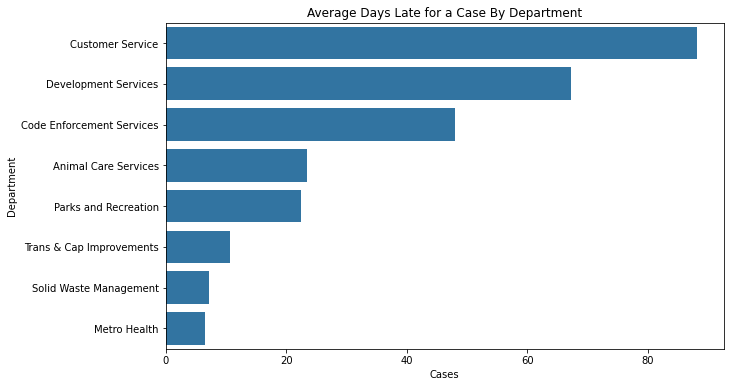

In [41]:
plt.figure(figsize=(10, 6))
sns.barplot(x="avg_days_late", y="dept_name", data=avg_late_by_dept, color="tab:blue")
plt.title('Average Days Late for a Case By Department')
plt.xlabel('Cases')
plt.ylabel('Department')
plt.show()

- What is the service type that is the most late? Just for Parks & Rec?


In [42]:
late_service = spark.sql('''
SELECT service_request_type, COUNT(service_request_type) AS num_late_service_req
FROM df
WHERE case_late = "YES"
GROUP BY service_request_type
SORT BY num_late_service_req DESC
LIMIT 10
''').toPandas()

In [52]:
late_service.sort_values('num_late_service_req', ascending = False).head(10)

service_request_type  num_late_service_req
0          Trapped/Confined Animal                  5829
1                        No Pickup                  5657
2  Aggressive Animal(Non-Critical)                  5337
3                   Animal Neglect                  4704
4     Solid Waste Fees and Charges                  4500
5                     Damaged Cart                  4280
6      Aggressive Animal(Critical)                  4134
7       Front Or Side Yard Parking                  3963
8                     Bandit Signs                  3830
9            Cart Exchange Request                  3545

22/02/15 18:50:13 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 332237 ms exceeds timeout 120000 ms
22/02/15 18:50:13 WARN SparkContext: Killing executors is not supported by current scheduler.


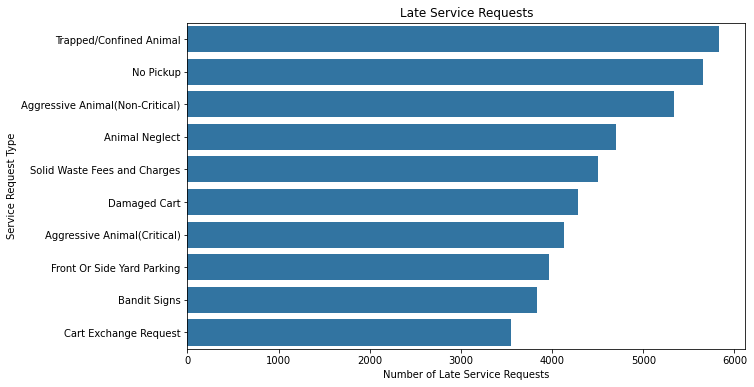

In [46]:
plt.figure(figsize=(10, 6))
sns.barplot(x="num_late_service_req", y="service_request_type", data=late_service, color="tab:blue")
plt.title('Late Service Requests')
plt.xlabel('Number of Late Service Requests')
plt.ylabel('Service Request Type')
plt.show()

- For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.


In [47]:
df.show(1, vertical=True, truncate=False)


-RECORD 0------------------------------------------------------
 source_id              | svcCRMLS                             
 dept_division          | Field Operations                     
 case_id                | 1014127332                           
 case_opened_date       | 1/1/18 0:42                          
 case_closed_date       | 1/1/18 12:29                         
 SLA_due_date           | 9/26/20 0:42                         
 case_late              | NO                                   
 num_days_late          | -998.5087616000001                   
 case_closed            | YES                                  
 service_request_type   | Stray Animal                         
 SLA_days               | 999.0                                
 case_status            | Closed                               
 request_address        | 2315  EL PASO ST, San Antonio, 78207 
 council_district       | 5                                    
 dept_name              | Animal Care Se

- Does whether or not its a weekend matter for when a case is opened/closed?


In [49]:
weekdays = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']


- On average, how many cases are opened a day for the Customer Service department?


- Does the number of service requests for the solid waste department vary by day of the week?